## 1. Import packages

Some advice on better training: https://github.com/stardist/stardist/issues/36

Yes, that would be the case. Although for dense image segmentation it is not really the number of images that matters, but the number of labels and they scale with the image size (as every pixel is practically a single label). One does therefore not really gain much by subdividing the image (apart from having effectively a smaller batchsize) but might loos something due to the border effect. I would thus suggest using the single full stack and do the flip augmentation on it. Additionally I would shift the intensity globally and add noise for augmentation (to increase robustness). Btw, you can do every augmentation on the fly by providing augmenter=aug_func to model.train (where x2,y2 = aug_func(x,y) transforms single image/mask pairs).

Also check out predict_big

In [1]:
# make sure the package autoreloads
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

import tensorflow as tf
print(f" TENSORFLOW : {tf.__version__}")


2023-04-29 03:30:44.827328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 TENSORFLOW : 2.11.0


## 2. Prepare patches

In [3]:
!pwd

/ply/repos/u01/synapse/inhipy/notebooks


### 2.1. Load data

In [4]:
patch_dir = "/ply/repos/u01/synapse/data/synapse_detection/classified_manual/gad1b_patches_32/"
# get the filenames in all the folders
X = sorted(glob(patch_dir + '*/img/*.tif'))
Y = sorted(glob(patch_dir + '*/seg/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1

In [5]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly for RGB data

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 719/719 [00:00<00:00, 818.36it/s]


In [6]:
assert len(X) > 1, "not enough training data"
print(f"Number of patches: {len(X)}")

Number of patches: 719


### 2.2. Split into training and validation data

In [7]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print(f'number of images: {len(X)}')
print(f'- training:       {len(X_trn)}')
print(f'- validation:     {len(X_val)}')

number of images: 719
- training:       611
- validation:     108


Plot some examples

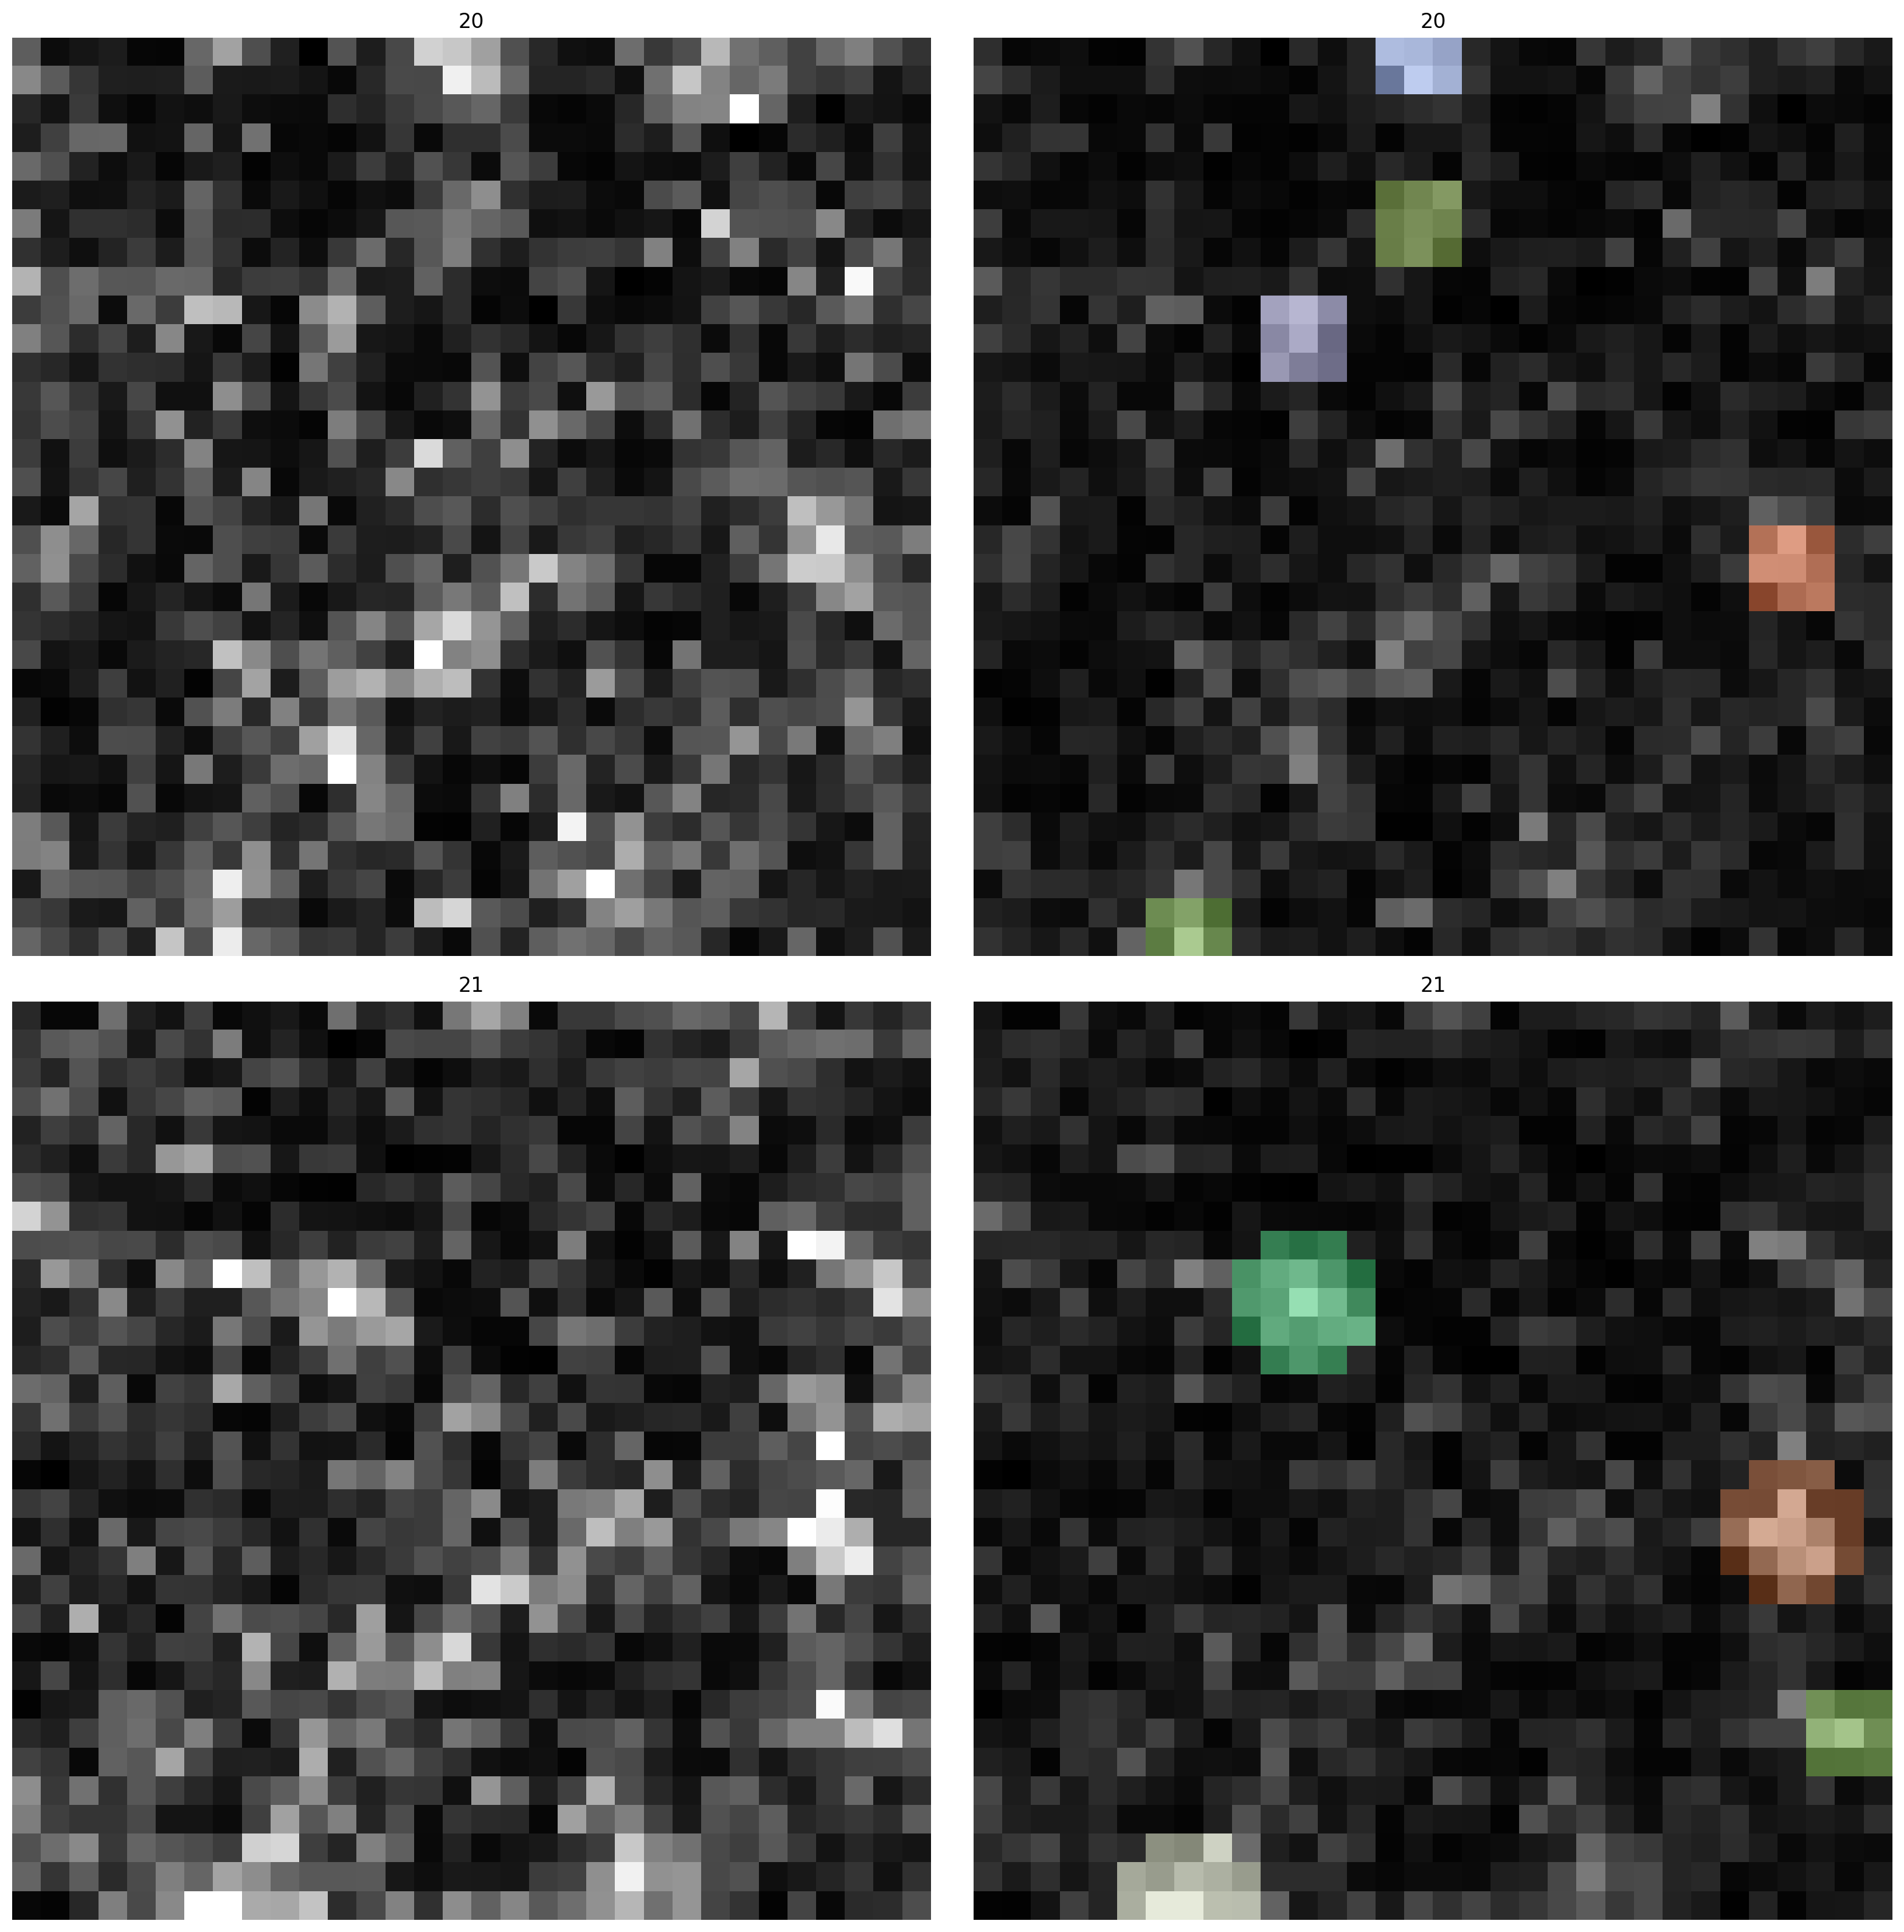

In [8]:
from inhipy.utils.plotter import plot_slice_with_insert
from inhipy.segmentation.preprocess import plot_segmentation_example

i = 500
img, lbl = X[i], Y[i]

plot_segmentation_example(img, lbl, vmin = 0, vmax = 1, show_slices = [20,21])

## 3. Configure and train network

In [9]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [10]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.6666666666666667, 1.0, 1.0)


In [11]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 16

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1, 1, 1) # tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (32,32,32),
    train_batch_size = 100,
    train_epochs = 100,
)
print(conf)
vars(conf)

Config3D(anisotropy=(1.6666666666666667, 1.0, 1.0), axes='ZYXC', backbone='unet', grid=(1, 1, 1), n_channel_in=1, n_channel_out=17, n_classes=None, n_dim=3, n_rays=16, net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 16, 'anisotropy': (1.6666666666666667, 1.0, 1.0)}}, train_background_reg=0.0001, train_batch_size=100, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_dist_loss='mae', train_epochs=100, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(32, 32, 32), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3, 3), unet_last

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 17,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 16,
 'grid': (1, 1, 1),
 'anisotropy': (1.6666666666666667, 1.0, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 16, 'anisotropy': (1.6666666666666667, 1.0, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (32, 32, 32),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.

In [12]:
# Indicate that the data generator should use OpenCL to do computations on the GPU.
print(f"use_gpu = {use_gpu}")
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

use_gpu = False


In [13]:
def random_fliprot(img, mask, axis=None):
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)

    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(transpose_axis)
    for ax in axis:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y

In [14]:
models_dir = "/ply/repos/u01/synapse/inhipy/models/01_Synapse_Stardist_Train/"

# strategy = tf.distribute.MirroredStrategy() breaks the Kernel ...
# Solutions from here: https://github.com/tensorflow/tensorflow/issues/36510
# 1. Setting strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice()) works but slows down training.
# 2. People seem to like : strategy = tf.distribute.MirroredStrategy(devices = gpu_devices_list, cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
# 3. some note on w&b: 
#       Once I found that using strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) worked, I proceeded ...
#       What I want to mention is that I was also using the Weights&Biases logging library. 
#       If I activated logging, I had to set strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice()) instead.
#
# some more notes from the docs https://www.tensorflow.org/guide/distributed_training
# If you wish to override the cross device communication, you can do so using the cross_device_ops argument by supplying an instance of tf.distribute.CrossDeviceOps. 
# Currently, tf.distribute.HierarchicalCopyAllReduce and tf.distribute.ReductionToOneDevice are two options other than tf.distribute.NcclAllReduce, which is the default.

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with strategy.scope(): 
    model = StarDist3D(conf, name = 'v0.0.1', basedir = models_dir)
    median_size = calculate_extents(Y, np.median)
    fov = np.array(model._axes_tile_overlap('ZYX'))
    print(f"median object size:      {median_size}")
    print(f"network field of view :  {fov}")
    if any(median_size > fov):
        print("WARNING: median object size larger than field of view of the neural network.")
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

2023-04-29 03:30:52.922609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 03:30:52.922823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 03:30:52.924514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 03:30:52.924687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 03:30:52.924846: I tensorflow/compiler/xla/stream_executo

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow | Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Using default values: prob_thresh=0.5, nms_thresh=0.4.


base_model.py (149): output path for model already exists, files may be overwritten: /ply/repos/u01/synapse/inhipy/models/01_Synapse_Stardist_Train/v0.0.1
2023-04-29 03:30:56.654154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 0s 86ms/step
median object size:      [3. 5. 5.]
network field of view :  [23 23 23]
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/100


2023-04-29 03:30:58.725098: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:56"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1


INFO:tensorflow | batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1


Cause: Unable to locate the source code of <function _gcd_import at 0x7f8511af0430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f8511af0430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f8511af0430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow | Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1


INFO:tensorflow | batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1
2023-04-29 03:31:04.538284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-29 03:31:07.916309: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8220ac1670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-29 03:31:07.916341: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-29 03:31:07.916349: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-29 03:31:07.920264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-29 03:31:08.023215: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled 

100/100 [==============================] - 48s 378ms/step - loss: 0.2962 - prob_loss: 0.0915 - dist_loss: 1.0236 - prob_kld: 0.0808 - dist_relevant_mae: 1.0234 - dist_relevant_mse: 1.9649 - dist_dist_iou_metric: 0.3820 - val_loss: 0.1803 - val_prob_loss: 0.0362 - val_dist_loss: 0.7205 - val_prob_kld: 0.0283 - val_dist_relevant_mae: 0.7202 - val_dist_relevant_mse: 0.9715 - val_dist_dist_iou_metric: 0.4902 - lr: 3.0000e-04
Epoch 2/100
100/100 [==============================] - 34s 343ms/step - loss: 0.1841 - prob_loss: 0.0415 - dist_loss: 0.7134 - prob_kld: 0.0319 - dist_relevant_mae: 0.7132 - dist_relevant_mse: 0.9577 - dist_dist_iou_metric: 0.5030 - val_loss: 0.1732 - val_prob_loss: 0.0341 - val_dist_loss: 0.6954 - val_prob_kld: 0.0262 - val_dist_relevant_mae: 0.6952 - val_dist_relevant_mse: 0.9552 - val_dist_dist_iou_metric: 0.5042 - lr: 3.0000e-04
Epoch 3/100
100/100 [==============================] - 34s 343ms/step - loss: 0.1615 - prob_loss: 0.0342 - dist_loss: 0.6365 - prob_kld: 0

In [15]:
model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 86ms/step


NMS threshold = 0.5:  80%|████████  | 16/20 [00:07<00:01,  2.25it/s, 0.427 -> 0.278]


Using optimized values: prob_thresh=0.427093, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.4270929247502968, 'nms': 0.4}

Example of true synapses: 

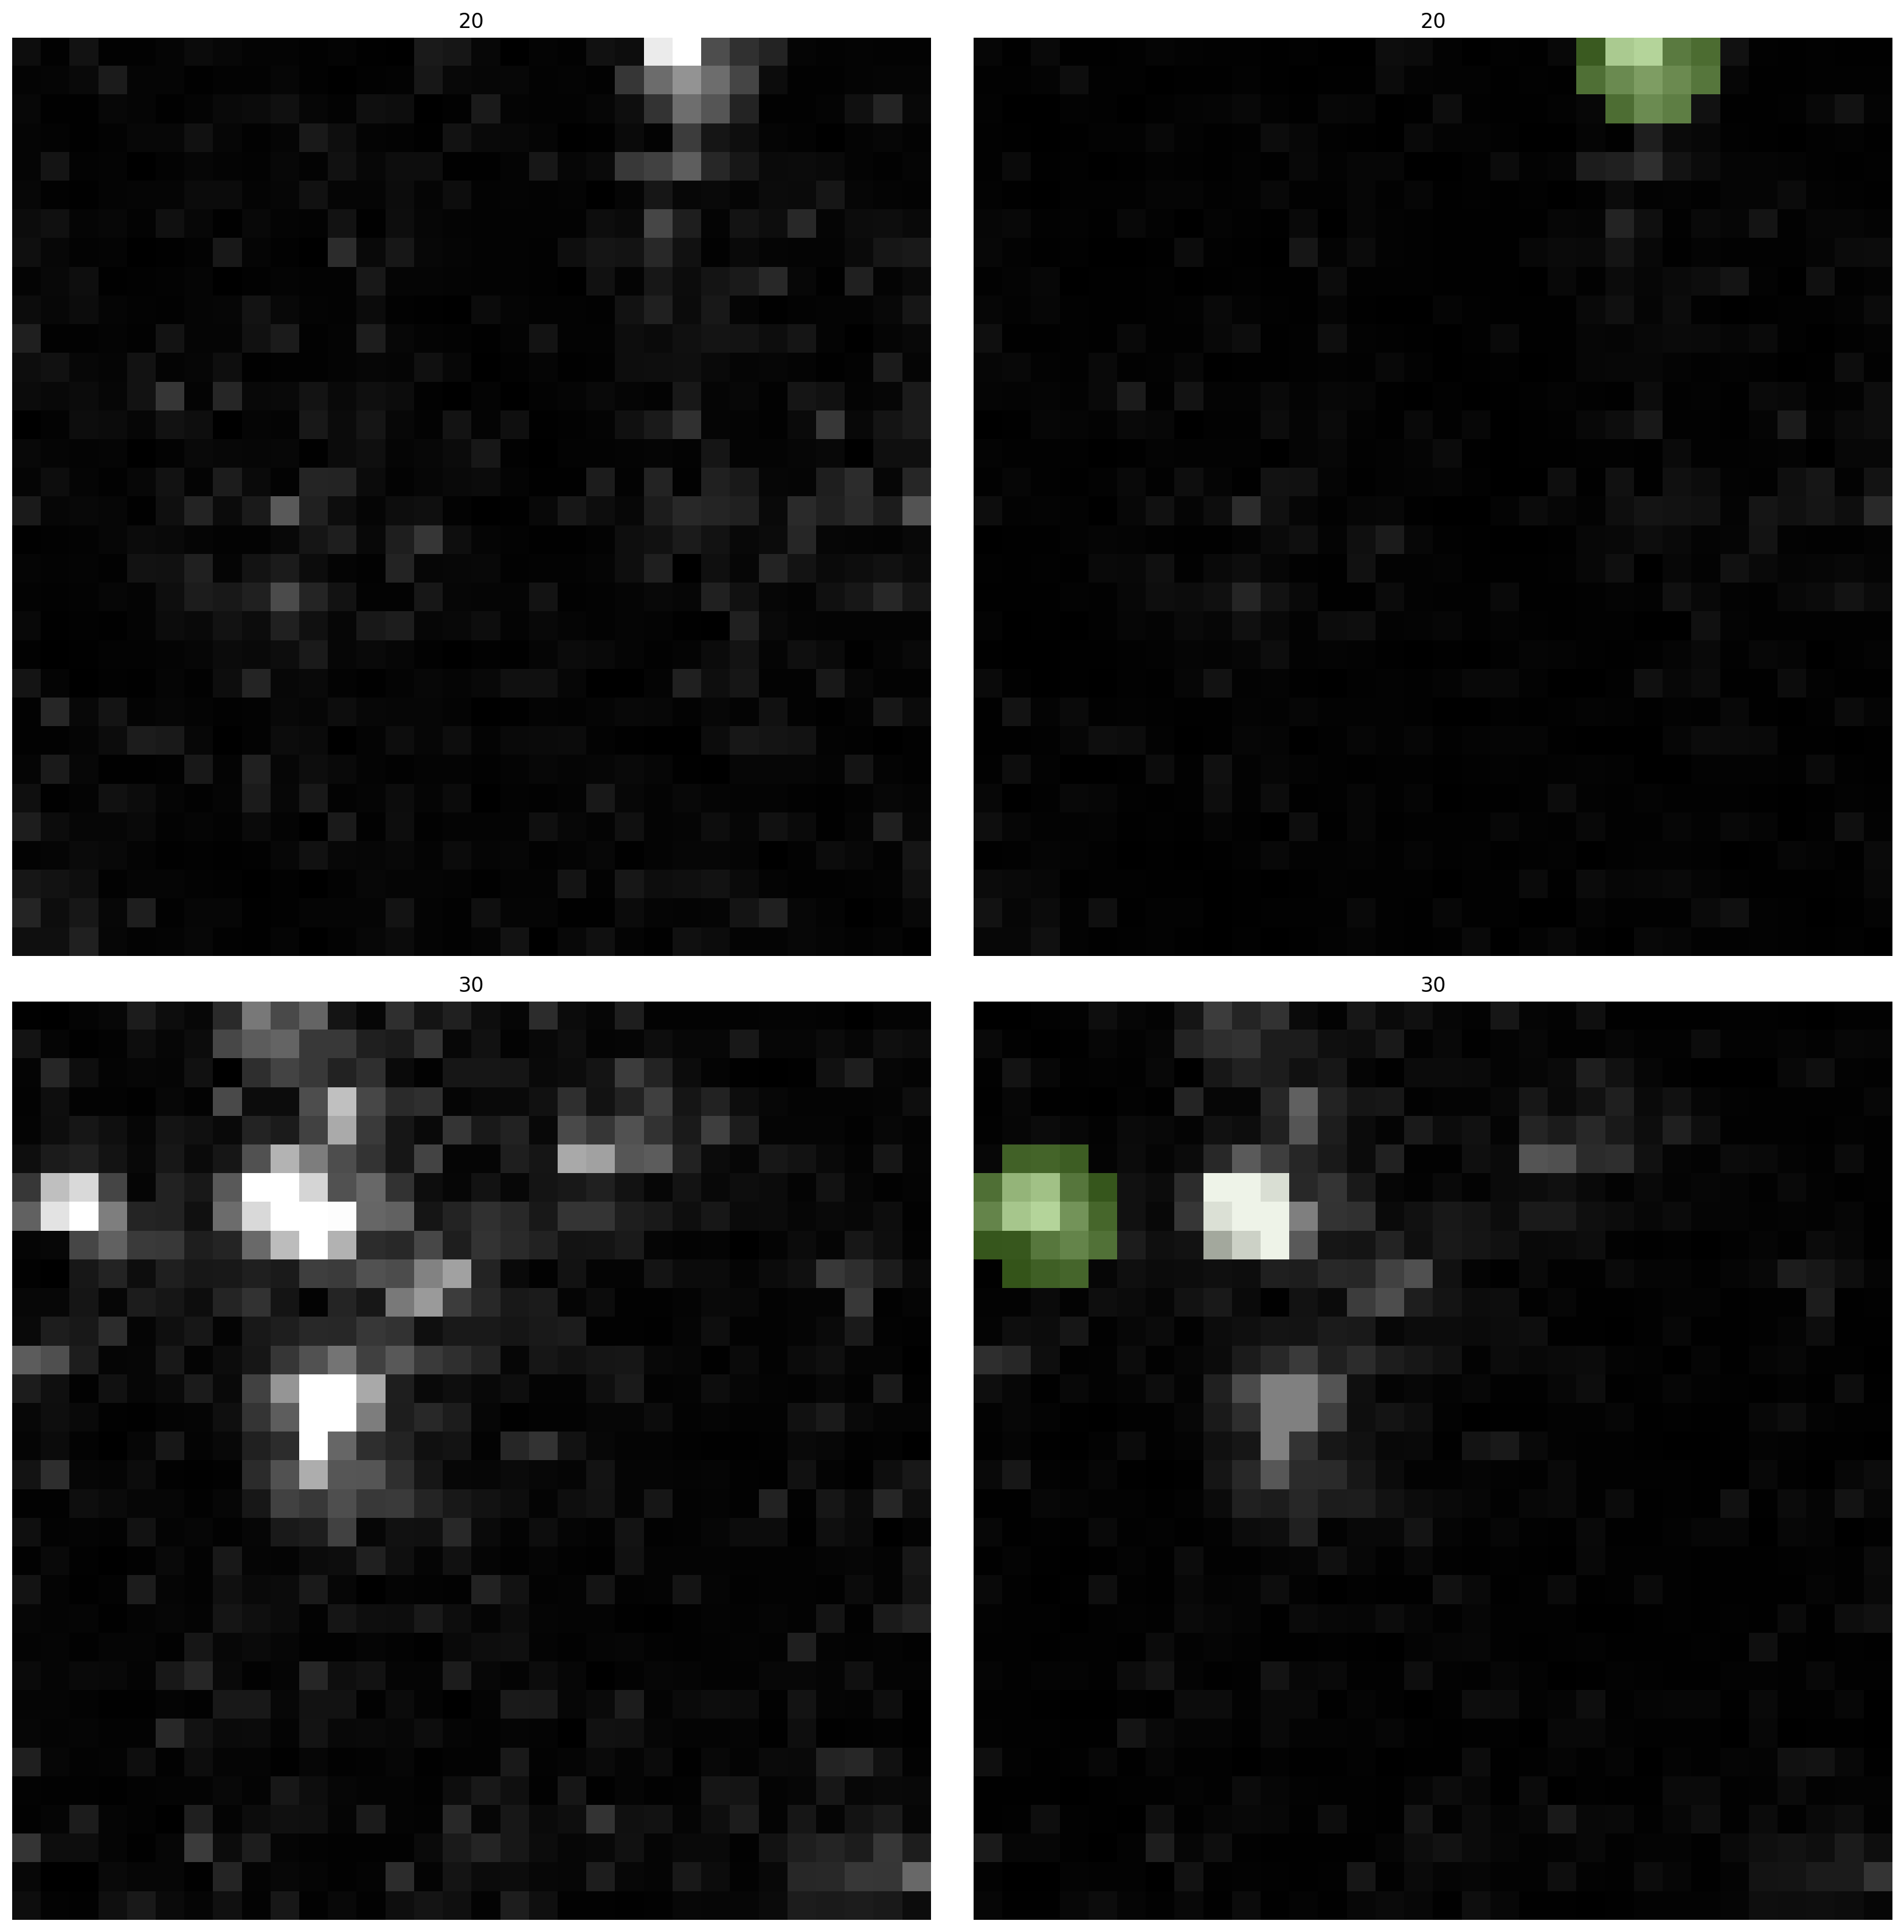

In [21]:
plot_segmentation_example(X_val[0],Y_val[0], vmin = 0, vmax = 1, show_slices = [20, 30])

Predicted:

In [33]:
p, d = model.predict_instances(X_val[0], show_tile_progress=False)
d.keys()

1/1 [==============================] - 0s 95ms/step


dict_keys(['dist', 'points', 'prob', 'rays', 'rays_vertices', 'rays_faces'])

In [39]:
d['rays']

Rays_GoldenSpiral_anisotropy_1.67_1.00_1.00_n_16

In [40]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/108 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


  1%|          | 1/108 [00:00<00:18,  5.73it/s]

1/1 [==============================] - 0s 75ms/step


  2%|▏         | 2/108 [00:00<00:15,  6.99it/s]

1/1 [==============================] - 0s 73ms/step


  3%|▎         | 3/108 [00:00<00:13,  7.60it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▎         | 4/108 [00:00<00:13,  7.81it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▍         | 5/108 [00:00<00:13,  7.67it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 6/108 [00:00<00:13,  7.83it/s]

1/1 [==============================] - 0s 74ms/step


  6%|▋         | 7/108 [00:00<00:12,  7.89it/s]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 8/108 [00:01<00:12,  7.90it/s]

1/1 [==============================] - 0s 74ms/step


  8%|▊         | 9/108 [00:01<00:12,  7.86it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 10/108 [00:01<00:12,  7.93it/s]

1/1 [==============================] - 0s 76ms/step


 10%|█         | 11/108 [00:01<00:11,  8.15it/s]

1/1 [==============================] - 0s 72ms/step


 11%|█         | 12/108 [00:01<00:11,  8.23it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 13/108 [00:01<00:11,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


 13%|█▎        | 14/108 [00:01<00:11,  8.19it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 15/108 [00:01<00:11,  8.23it/s]

1/1 [==============================] - 0s 74ms/step


 15%|█▍        | 16/108 [00:02<00:11,  8.14it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 17/108 [00:02<00:10,  8.30it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█▋        | 18/108 [00:02<00:11,  8.07it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 19/108 [00:02<00:11,  8.04it/s]

1/1 [==============================] - 0s 76ms/step


 19%|█▊        | 20/108 [00:02<00:11,  7.52it/s]

1/1 [==============================] - 0s 73ms/step


 19%|█▉        | 21/108 [00:02<00:11,  7.84it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 22/108 [00:02<00:10,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██▏       | 23/108 [00:02<00:10,  8.00it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 24/108 [00:03<00:10,  8.01it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██▎       | 25/108 [00:03<00:10,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 26/108 [00:03<00:09,  8.22it/s]

1/1 [==============================] - 0s 72ms/step


 25%|██▌       | 27/108 [00:03<00:10,  8.09it/s]

1/1 [==============================] - 0s 73ms/step


 26%|██▌       | 28/108 [00:03<00:09,  8.07it/s]

1/1 [==============================] - 0s 72ms/step


 27%|██▋       | 29/108 [00:03<00:09,  8.24it/s]

1/1 [==============================] - 0s 75ms/step


 28%|██▊       | 30/108 [00:03<00:09,  8.28it/s]

1/1 [==============================] - 0s 72ms/step


 29%|██▊       | 31/108 [00:03<00:09,  8.29it/s]

1/1 [==============================] - 0s 75ms/step


 30%|██▉       | 32/108 [00:03<00:09,  8.38it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 33/108 [00:04<00:08,  8.42it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███▏      | 34/108 [00:04<00:09,  8.09it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 35/108 [00:04<00:09,  7.81it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 36/108 [00:04<00:09,  7.99it/s]

1/1 [==============================] - 0s 329ms/step


 34%|███▍      | 37/108 [00:04<00:14,  5.00it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▌      | 38/108 [00:05<00:12,  5.50it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███▌      | 39/108 [00:05<00:11,  5.90it/s]

1/1 [==============================] - 0s 94ms/step


 37%|███▋      | 40/108 [00:05<00:11,  6.16it/s]

1/1 [==============================] - 0s 87ms/step


 38%|███▊      | 41/108 [00:05<00:10,  6.49it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 42/108 [00:05<00:10,  6.44it/s]

1/1 [==============================] - 0s 84ms/step


 40%|███▉      | 43/108 [00:05<00:09,  6.77it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 44/108 [00:05<00:09,  7.07it/s]

1/1 [==============================] - 0s 85ms/step


 42%|████▏     | 45/108 [00:05<00:08,  7.03it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 46/108 [00:06<00:08,  7.26it/s]

1/1 [==============================] - 0s 87ms/step


 44%|████▎     | 47/108 [00:06<00:08,  7.26it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▍     | 48/108 [00:06<00:08,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


 45%|████▌     | 49/108 [00:06<00:08,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▋     | 50/108 [00:06<00:07,  7.39it/s]

1/1 [==============================] - 0s 79ms/step


 47%|████▋     | 51/108 [00:06<00:07,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


 48%|████▊     | 52/108 [00:06<00:07,  7.54it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▉     | 53/108 [00:07<00:07,  7.62it/s]

1/1 [==============================] - 0s 82ms/step


 50%|█████     | 54/108 [00:07<00:07,  7.63it/s]

1/1 [==============================] - 0s 77ms/step


 51%|█████     | 55/108 [00:07<00:06,  7.61it/s]

1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 56/108 [00:07<00:06,  7.71it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 57/108 [00:07<00:06,  7.71it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 58/108 [00:07<00:06,  7.69it/s]

1/1 [==============================] - 0s 79ms/step


 55%|█████▍    | 59/108 [00:07<00:06,  7.76it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 60/108 [00:07<00:06,  7.86it/s]

1/1 [==============================] - 0s 81ms/step


 56%|█████▋    | 61/108 [00:08<00:05,  7.92it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 62/108 [00:08<00:05,  7.84it/s]

1/1 [==============================] - 0s 74ms/step


 58%|█████▊    | 63/108 [00:08<00:05,  8.07it/s]

1/1 [==============================] - 0s 79ms/step


 59%|█████▉    | 64/108 [00:08<00:05,  7.80it/s]

1/1 [==============================] - 0s 74ms/step


 60%|██████    | 65/108 [00:08<00:05,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 61%|██████    | 66/108 [00:08<00:05,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 67/108 [00:08<00:05,  7.98it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 68/108 [00:08<00:05,  7.95it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 69/108 [00:09<00:04,  8.05it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 70/108 [00:09<00:04,  8.16it/s]

1/1 [==============================] - 0s 77ms/step


 66%|██████▌   | 71/108 [00:09<00:04,  8.25it/s]

1/1 [==============================] - 0s 74ms/step


 67%|██████▋   | 72/108 [00:09<00:04,  8.25it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 73/108 [00:09<00:04,  8.05it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▊   | 74/108 [00:09<00:04,  8.04it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 75/108 [00:09<00:04,  8.14it/s]

1/1 [==============================] - 0s 78ms/step


 70%|███████   | 76/108 [00:09<00:03,  8.19it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████▏  | 77/108 [00:10<00:03,  8.21it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 78/108 [00:10<00:03,  8.26it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 79/108 [00:10<00:03,  8.15it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 80/108 [00:10<00:03,  8.20it/s]

1/1 [==============================] - 0s 75ms/step


 75%|███████▌  | 81/108 [00:10<00:03,  7.97it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▌  | 82/108 [00:10<00:03,  7.92it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 83/108 [00:10<00:03,  8.08it/s]

1/1 [==============================] - 0s 80ms/step


 78%|███████▊  | 84/108 [00:10<00:03,  7.92it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▊  | 85/108 [00:11<00:02,  8.00it/s]

1/1 [==============================] - 0s 76ms/step


 80%|███████▉  | 86/108 [00:11<00:02,  7.89it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████  | 87/108 [00:11<00:02,  8.02it/s]

1/1 [==============================] - 0s 84ms/step


 81%|████████▏ | 88/108 [00:11<00:02,  7.87it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 89/108 [00:11<00:02,  7.89it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 90/108 [00:11<00:02,  7.93it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 91/108 [00:11<00:02,  8.09it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 92/108 [00:11<00:01,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 93/108 [00:12<00:01,  8.06it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 94/108 [00:12<00:01,  8.10it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 95/108 [00:12<00:01,  8.13it/s]

1/1 [==============================] - 0s 74ms/step


 89%|████████▉ | 96/108 [00:12<00:01,  8.24it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 97/108 [00:12<00:01,  8.07it/s]

1/1 [==============================] - 0s 73ms/step


 91%|█████████ | 98/108 [00:12<00:01,  8.05it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 99/108 [00:12<00:01,  8.36it/s]

1/1 [==============================] - 0s 82ms/step


 93%|█████████▎| 100/108 [00:12<00:00,  8.17it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▎| 101/108 [00:13<00:00,  8.03it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████▍| 102/108 [00:13<00:00,  7.11it/s]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 103/108 [00:13<00:00,  7.31it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▋| 104/108 [00:13<00:00,  7.55it/s]

1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 105/108 [00:13<00:00,  7.78it/s]

1/1 [==============================] - 0s 78ms/step


 98%|█████████▊| 106/108 [00:13<00:00,  7.92it/s]

1/1 [==============================] - 0s 77ms/step


 99%|█████████▉| 107/108 [00:13<00:00,  7.92it/s]

1/1 [==============================] - 0s 80ms/step


100%|██████████| 108/108 [00:13<00:00,  7.74it/s]


In [41]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  8.76it/s]


In [42]:
stats[taus.index(0.6)]

DatasetMatching(criterion='iou', thresh=0.6, fp=364, tp=580, fn=932, precision=0.614406779661017, recall=0.3835978835978836, accuracy=0.3091684434968017, f1=0.4723127035830619, n_true=1512, n_pred=944, mean_true_score=0.2723524498718756, mean_matched_score=0.7099946624246137, panoptic_quality=0.33533949853931266, by_image=False)

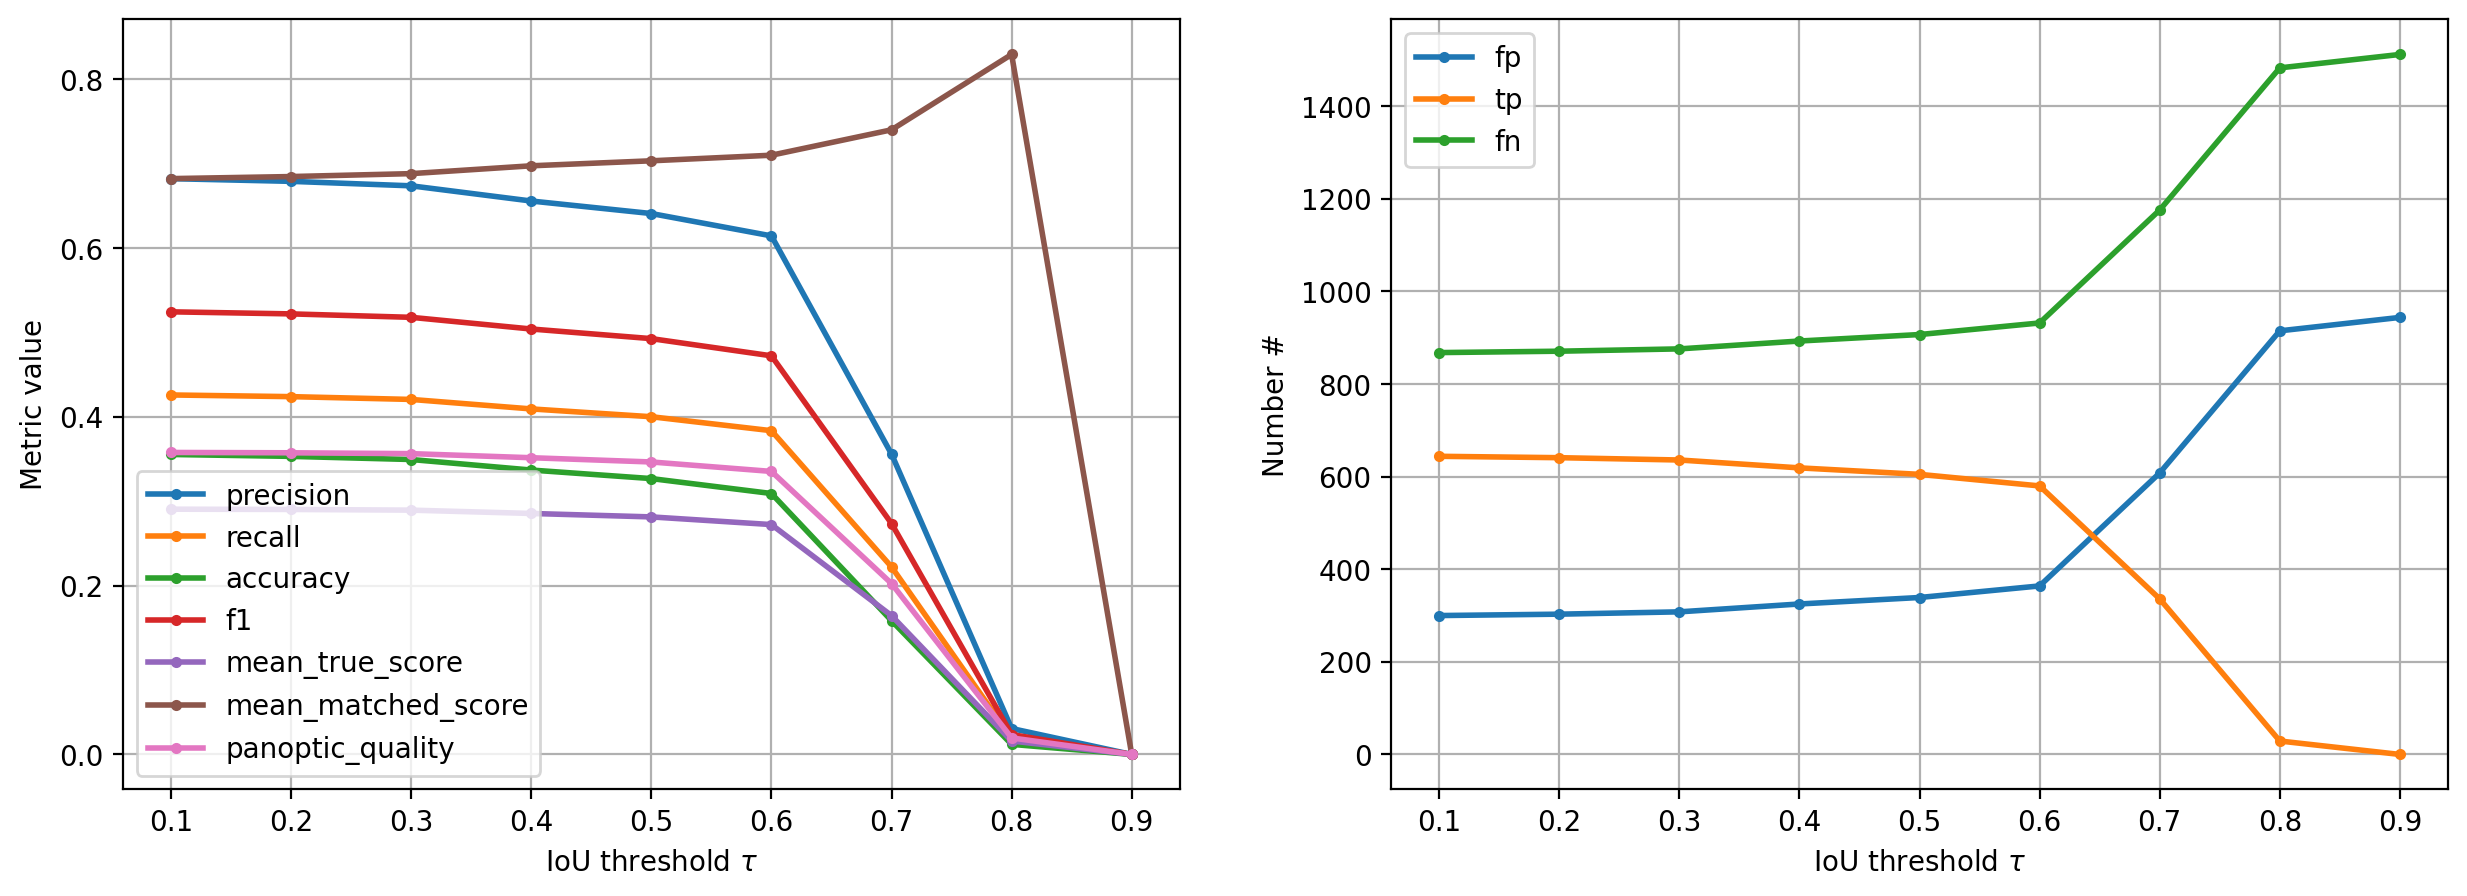

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();